<a href="https://colab.research.google.com/github/babatundeibukun/DEEP-LEARNING-PROJECT---COMPUTER/blob/main/transfer_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf


import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

classifier_model = mobilenet_v2

In [3]:
!pip install tensorflow==2.8.0  # or another compatible version
!pip install tensorflow-hub==0.12.0


In [11]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf


import tensorflow_hub as hub

import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

#Run it on a single image
Download a single image to try the model on:



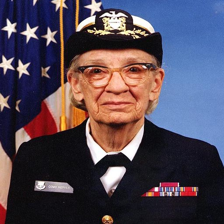

In [14]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [15]:
print(type(grace_hopper))


<class 'PIL.Image.Image'>


In [16]:
import numpy as np

# Assuming grace_hopper is a string representation of an array
grace_hopper = np.array(grace_hopper)  # Be cautious with eval


In [17]:
grace_hopper = grace_hopper/255.0
grace_hopper.shape

(224, 224, 3)

#Add a batch dimension (with np.newaxis) and pass the image to the model:



In [18]:
#the reason we are doing this , adding one more dimension to our work is because in prediction we need multiple input
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [22]:
result

array([[ 0.19967607,  1.0678943 , -0.09609922, ...,  0.10602923,
        -0.56032073, -0.07089066]], dtype=float32)

#The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with tf.math.argmax:

In [19]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

#Decode the predictions
Take the predicted_class ID (such as 653) and fetch the ImageNet dataset labels to decode the predictions:

In [20]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


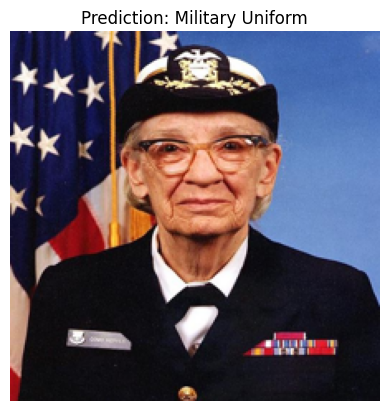

In [21]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

#The above looks great , we did classification straight away with our pre-trained model

But what if we have our own dataset , how do we do a classification for them? this is what we are about to get into, ready?

#Simple transfer learning
But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

Select a pre-trained model from TensorFlow Hub; and
Retrain the top (last) layer to recognize the classes from your custom dataset.

In [53]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [54]:
data_dir

'./datasets/flower_photos'

#the above is string path, we need to convert to windows path so that we can iterate and work with the file path of each flowers.

In [55]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

#below is all the windows path

In [56]:
list(data_dir.glob('*/*.jpg'))[:5]


[PosixPath('datasets/flower_photos/daisy/2488902131_3417698611_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/4865691548_00319261b8.jpg'),
 PosixPath('datasets/flower_photos/daisy/2573240560_ff7ffdd449.jpg'),
 PosixPath('datasets/flower_photos/daisy/4281102584_c548a69b81_m.jpg'),
 PosixPath('datasets/flower_photos/daisy/4511693548_20f9bd2b9c_m.jpg')]

#below is the total number of flowers in our dataset

In [57]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


#All the roses

In [58]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/5148639829_781eb7d346.jpg'),
 PosixPath('datasets/flower_photos/roses/3554620445_082dd0bec4_n.jpg'),
 PosixPath('datasets/flower_photos/roses/12434194695_a7c4e73c6b_n.jpg'),
 PosixPath('datasets/flower_photos/roses/512578026_f6e6f2ad26.jpg'),
 PosixPath('datasets/flower_photos/roses/3026375835_a20ecdd140_m.jpg')]

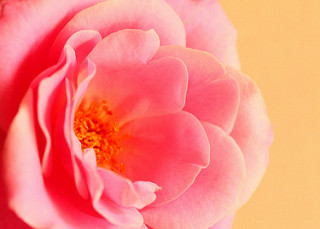

In [59]:
Image.open(str(roses[1]))


#Tulips

In [60]:
tulips = list(data_dir.glob('tulips/*'))
tulips[:5]

[PosixPath('datasets/flower_photos/tulips/6931674908_8e93bd4554.jpg'),
 PosixPath('datasets/flower_photos/tulips/16582481123_06e8e6b966_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/3614805920_7a6610aa4b_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/16765283686_0315ae00a8.jpg'),
 PosixPath('datasets/flower_photos/tulips/8712266605_3787e346cd_n.jpg')]

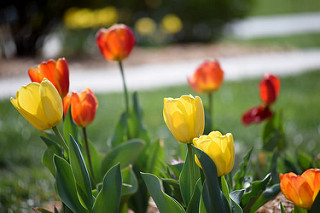

In [61]:
Image.open(str(tulips[1]))


In [62]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [63]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [64]:
str(flowers_images_dict['roses'][0])


'datasets/flower_photos/roses/5148639829_781eb7d346.jpg'

array([[[106,  98,  99],
        [103,  99,  98],
        [ 96,  97,  93],
        ...,
        [111, 121, 115],
        [101, 112, 104],
        [104, 115, 105]],

       [[101, 105,  99],
        [108, 111, 102],
        [ 90, 107,  94],
        ...,
        [119, 107, 101],
        [113, 103,  96],
        [138, 129, 120]],

       [[100,  94,  89],
        [ 92, 113, 104],
        [ 80, 106,  93],
        ...,
        [129, 119, 109],
        [123, 113, 103],
        [127, 118, 108]],

       ...,

       [[ 29,  48,  53],
        [ 20,  39,  36],
        [ 18,  34,  41],
        ...,
        [ 16,  47,  56],
        [ 11,  39,  50],
        [ 29,  53,  73]],

       [[ 22,  38,  45],
        [ 15,  28,  30],
        [ 33,  55,  67],
        ...,
        [ 25,  43,  54],
        [ 24,  40,  52],
        [ 24,  38,  56]],

       [[ 49,  55,  66],
        [  7,  26,  31],
        [ 31,  58,  72],
        ...,
        [ 35,  51,  67],
        [ 17,  36,  49],
        [ 25,  42,  61]]], dtype=uint8)
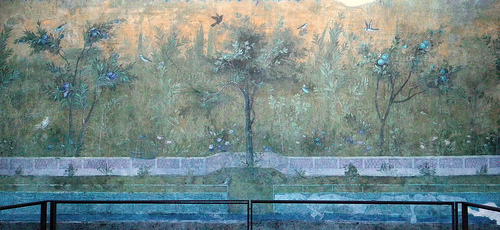

In [65]:
import cv2

img = cv2.imread(str(flowers_images_dict['roses'][0]))
img

In [66]:
cv2.resize(img,IMAGE_SHAPE).shape


(224, 224, 3)

In [67]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(IMAGE_SHAPE))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [68]:
import  numpy as np
X = np.array(X)
y = np.array(y)

In [69]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [70]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

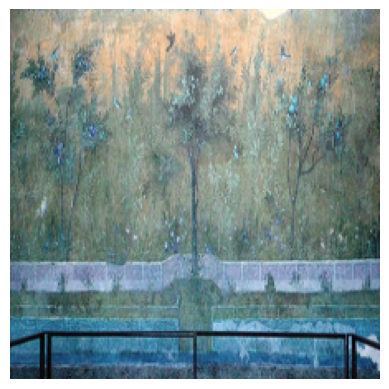

In [71]:
plt.axis('off')
plt.imshow(X[0])

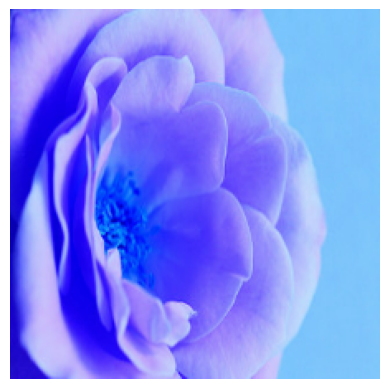

In [72]:
plt.axis('off')
plt.imshow(X[1])

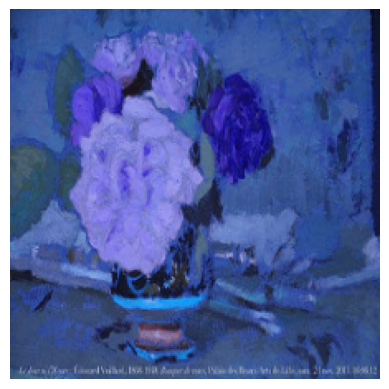

In [73]:
plt.axis('off')
plt.imshow(X[2])

In [76]:
classifier.predict(np.array([X[0],X[1],[2]]))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [77]:
# Stack the images along a new dimension to create a batch
batch = np.stack([X[0], X[1], X[2]])

# Make predictions on the batch
predicted = classifier.predict(batch)


In [78]:
predicted = np.argmax(predicted , axis =1)
predicted

array([795, 795, 795])

In [80]:
imagenet_labels[795]

'shower curtain'

#now lets retrain the model by using only the last layer

In [81]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)


In [82]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [83]:
model.compile(
  optimizer= 'adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs = 5)


Epoch 1/5
86/86 [==============================] - 68s 755ms/step - loss: 0.8009 - acc: 0.6937
Epoch 2/5
86/86 [==============================] - 66s 768ms/step - loss: 0.4171 - acc: 0.8568
Epoch 3/5
86/86 [==============================] - 64s 743ms/step - loss: 0.3274 - acc: 0.8877
Epoch 4/5
86/86 [==============================] - 63s 729ms/step - loss: 0.2719 - acc: 0.9153
Epoch 5/5
86/86 [==============================] - 60s 695ms/step - loss: 0.2348 - acc: 0.9295


In [84]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 19s 651ms/step - loss: 0.3535 - acc: 0.8725


[0.3534647524356842, 0.8725489974021912]